## Reddit: Webscraping and categorical prediction

### Executive Summary

In attempting to model the popularity of Reddit posts, as indicated by number of comments received,  information on where and when the post was initiated, and the structure of the title was used.  

The title was broken down into parts of speech and length. The hope was to give some indication of how important the strucuting of a title was for a post to become popular.  

In the end, the models created were able to predict whether or not a post would receive above the median number of comments between 70% and 75% of the time

### Step 1. Web Scraping

I used two methods for webscraping.  
The first were scrapy spiders which scraped the first 500, and sometime few thousand posts. Code used for the spiders can be found in the `items.py` file and in the spiders folder under `reddit_spider.py`  

The data from these spider scrapes are found in the 'Data' folder, but not in the 'Praw' subfolder.  

The second method for scraping was using Praw and the reddit api. Code found below.  
Data found in the 'Praw' subfolder of 'Data'.

#### Scraping with praw

In [11]:
import praw
import json
import time
import pandas as pd
import datetime
import numpy as np

%matplotlib inline

def prawScrape(num):
    with open('api_key.json') as f:
        keys = json.loads(f.read())
    
    reddit = praw.Reddit(client_id=keys['key'],
                         client_secret=keys['secret'],
                         user_agent='GAProj by wipegup')
    subList= []
    for s in reddit.subreddit('all').hot(limit = num):
        subList.append({'title':s.title, 'comments':s.num_comments,
        'score':s.score, 'subreddit':'r/'+ str(s.subreddit),
        'upvotes':s.ups, 'upvoteRatio':s.upvote_ratio,
        'timePosted':s.created_utc, 'timeScraped':time.time()})
    
    df = pd.DataFrame(subList)
    df['timePosted'] = [pd.to_datetime(datetime.datetime.fromtimestamp(t)) for t in df['timePosted']]
    df['timeScraped'] = [pd.to_datetime(datetime.datetime.fromtimestamp(t)) for t in df['timeScraped']]
    df['timePosted']=[t- pd.Timedelta(hours = 5) # convert from UTC
                            for t in df['timePosted']]
    
    df['timeUp'] = df['timeScraped'] - df['timePosted']
    
    return df

In [12]:
%%time
df = prawScrape(None)

Wall time: 42min 56s


In [13]:
df.to_csv('./Data/Praw/PrawFeb.25.1200.csv')

### Step 2: Munging

The scrapy-scraped data requires some wrangling to get into pandas-friendly format. The praw data was scraped more with an eye towards panda-friendliness.

### Functions for early scraping data

In [2]:
import datetime
import pandas as pd
import numpy as np

####
# Functions for data scraped using scrapy
####

def redditScrapedRead(path):
    
    df = pd.read_csv(path)
    
    df['timePosted'] = [pd.to_datetime(t[0:28]) - pd.Timedelta(hours = 5) # convert from UTC
                        for t in df['timePosted']] 
    df['timeScraped'] = [pd.to_datetime(datetime.datetime.fromtimestamp(t)) for t in df['timeScraped']]
    df['timeUp'] = df['timeScraped'] - df['timePosted']
    
    # Dropping features determined later to be vestigial
    if 'liveComments' in df.columns:
        df = df.drop('liveComments', axis = 1)
    if 'liveScore' in df.columns:
        df = df.drop('liveScore', axis = 1)
    if 'rank' in df.columns:
        df = df.drop('rank', axis = 1)
    
    return df

###########
### Testing Code for fullDupRows
#### dx=pd.concat([dfw,dfw,dfw,dfw],ignore_index=True)
#### dx.loc[[0,1,3,5,6],'subreddit'] = ['b','c','a','b','a']
#### dr = fullDupRows(dx, [])
###########

#########
## Function that returns a list of lists, being given a list of rows with the same title
## inner list are the index numbers of rows which are ostensibly the same post
### Mostly a helper function for removeDuplicates
########

def fullDupRows(data, toRet):
    compRow = data.iloc[0]
    toApp = [compRow.name]
    dfp = data.drop(compRow.name, axis = 0)
    dfm = dfp[(dfp['timePosted'] == compRow['timePosted']) &
              (dfp['subreddit'] ==compRow['subreddit'])]

    if len(dfm)>0:
        toApp.extend(dfm.index)

    dfn = dfp.drop(dfm.index)

    if len(dfn)>1:
        toRet = fullDupRows(dfn,toRet)

    if len(toApp)>1:
        toRet.append(toApp)
    return toRet


# Function for removing repeated obesrvations from scraped data

def removeDuplicates(data):
    
    #find all titles occuring more than once
    duplicates = data['title'].value_counts().to_frame()
    duplicates = duplicates[duplicates['title']>1]
    
    toAvg = []  # Container for all row indexes of a duplicate that need to be combined
    
    toRet = data.copy()
    
    for tit in duplicates.index:
        # for each title, pass a dataframe containing all rows with that title
        toAvg.extend(fullDupRows(data[data['title']==tit],[]))
    for l in toAvg:
        # combine rows into the top row through taking average of comments and score
        toRet.loc[l[0],['comments','score']] = [
                                                np.mean([toRet.loc[i,'comments'] for i in l]),
                                                np.mean([toRet.loc[i,'score'] for i in l])
                                                ]
        # then drop all but that averaged row
        toRet = toRet.drop(l[1:],)
    return toRet
        

### Combining the praw and scrape data

In [3]:
from os import listdir
from os.path import isfile, join

####
# Brings data in from scraped and Praw sources
####

def combineData(scrape, praw):
    scrapeFiles = [f for f in listdir(scrape) if isfile(join(scrape,f))]
    prawFiles = [f for f in listdir(praw) if isfile(join(praw,f))]
    
    frames = []
    for f in scrapeFiles:
        p = scrape + f
        frames.append(removeDuplicates(redditScrapedRead(p)))
    
    for f in prawFiles:
        p = praw + f
        frames.append(pd.read_csv(p, encoding = 'ISO-8859-1', index_col = 0))
    
    df = pd.concat(frames, axis = 'rows')
    df = df.drop(['timeScraped','upvoteRatio','upvotes'], axis = 'columns')
    return df

In [18]:
%%time
df = combineData('./Data/','./Data/Praw/')

Wall time: 17 s


### Step 3: Initial EDA

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

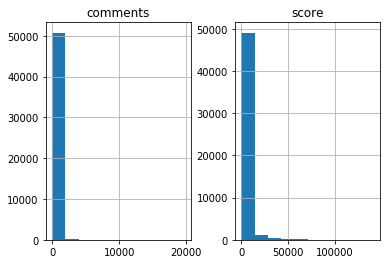

In [20]:
df.hist();

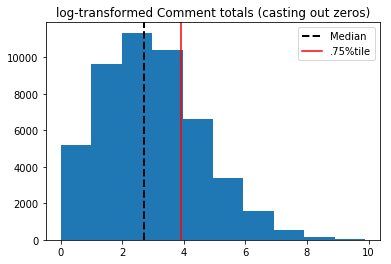

In [38]:
plt.hist(np.log(df[df['comments'] != 0]['comments']))
plt.title("log-transformed Comment totals (casting out zeros)");
plt.axvline(np.log(np.median(df['comments'])), c = 'black',linestyle='dashed', linewidth=2, label = 'Median');
plt.axvline(np.log(np.percentile(df['comments'], q= 75)), c = 'red', label = '.75%tile')
plt.legend();

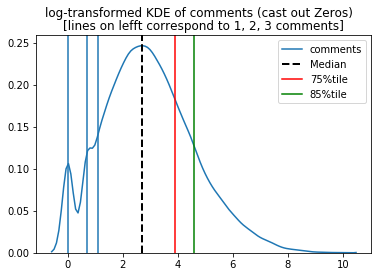

In [58]:
sns.kdeplot(np.log(df[df['comments'] != 0]['comments']))
plt.axvline(np.log(np.median(df['comments'])), c = 'black',linestyle='dashed', linewidth=2, label = 'Median');
plt.axvline(np.log(np.percentile(df['comments'], q= 75)), c = 'red', label = '75%tile')
plt.axvline(np.log(np.percentile(df['comments'], q= 85)), c = 'g', label = '85%tile')
plt.axvline(np.log(1))
plt.axvline(np.log(2))
plt.axvline(np.log(3))
plt.title('[lines on lefft correspond to 1, 2, 3 comments]')
plt.suptitle('log-transformed KDE of comments (cast out Zeros)')
plt.legend();

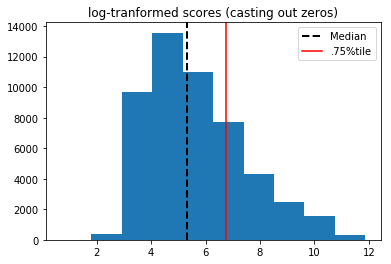

In [45]:
plt.hist(np.log(df[df['score'] != 0]['score']))
plt.title('log-tranformed scores (casting out zeros)');
plt.axvline(np.log(np.median(df['score'])), c = 'black',linestyle='dashed', linewidth=2, label = 'Median');
plt.axvline(np.log(np.percentile(df['score'], q= 75)), c = 'red', label = '.75%tile')
plt.legend();

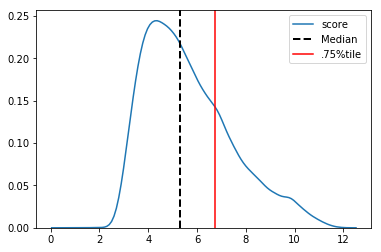

In [44]:
sns.kdeplot(np.log(df[df['score'] != 0]['score']))
plt.axvline(np.log(np.median(df['score'])), c = 'black',linestyle='dashed', linewidth=2, label = 'Median');
plt.axvline(np.log(np.percentile(df['score'], q= 75)), c = 'red', label = '.75%tile')

plt.legend();

Text(0.5,1,'Score v. Comments')

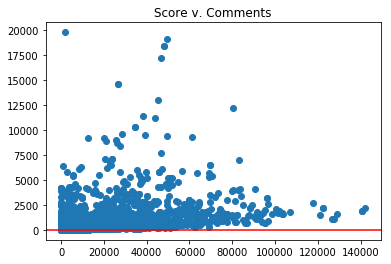

In [322]:
plt.scatter(df['score'], df['comments'])
plt.axhline(np.median(df['comments']), c = 'r')
plt.title('Score v. Comments')


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51017 entries, 0 to 9192
Data columns (total 6 columns):
comments      51017 non-null float64
score         51017 non-null float64
subreddit     51017 non-null object
timePosted    51017 non-null object
timeUp        51017 non-null object
title         51017 non-null object
dtypes: float64(2), object(4)
memory usage: 2.7+ MB


### Train-Test Split

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.drop('comments', axis = 'columns'),
                                                    df['comments'],
                                                    test_size = .2,
                                                    random_state = 1738)

### Pre-Processing Functions and Calculation of overall Statistics from Training Data

Feature creation mostly consists of determining the proportion and absolute number of parts of speech used in titles.  

Ratio of posts from each subreddit is also calculated

#### Function Definitions

In [49]:
import numpy as np
import spacy
nlp = spacy.load('en_core_web_sm')

####
# Create Dictionary with key of subreddit
# value of proportion of posts in that subreddit
####

def subredditRatio(data):
    srCount = data['subreddit'].value_counts().rename('SRCount')
    srCount = srCount.to_frame()
    srCount['SRCount'] = srCount['SRCount']/len(data)
    toRet = srCount.to_dict()
    
    return toRet

####
# Returns df with index as 0-len(df)
####

def reindex(data):
    toRet = data.copy()
    toRet.index = range(len(data))
    return toRet

####
# Adds data to given df from the 'title' variable
# For each post, calculates absolute number and ratio of each
# part of speech
# also adds feature of title length
####


def ratios(data):
    lst = []
    for l in data.index:
        par = nlp(data.loc[l,'title'])
        
        dfn = pd.DataFrame([token.pos_ for token in par], columns = ['pos'])
        dfn = dfn['pos'].value_counts().to_frame()
        
        dfn['pos_r'] = dfn['pos'] / dfn['pos'].sum()

        dfr = dfn['pos_r']
        dfr.index = [n + '_R' for n in dfr.index]
        
        dfn = dfr.append(dfn['pos'])
        dfn['length'] = len(par)
        
        row = data.loc[l].append(dfn)
       
        lst.append(row)
        
    dfRet = pd.DataFrame(lst)
    dfRet.fillna(0, inplace = True)
    
    return dfRet

####
# From a vector of comments, returns vector of T/F
# as to whether each number is greater or smaller than
# the median, either given or calculated
####

In [287]:
SRRatioDict = subredditRatio(X_train)['SRCount']

def target(data, commentsMed = 'calc'):
    
    if commentsMed == 'calc':
        commentsMed = np.median(data)
        
    return commentsMed, [c > commentsMed for c in data]

def targetPerc(data, perc = 60, commentsSplit = 'calc'):
    if commentsSplit == 'calc':
        commentsSplit = np.percentile(data, q = perc)
    
    return commentsSplit, [c > commentsSplit for c in data]

def preproc(X_data, y_data, subRatioDict):
    
    df = reindex(X_data)
    dfy = reindex(y_data)
    
    df['timePosted'] = pd.to_datetime(df['timePosted'])
    df['subredditRatio'] = df['subreddit'].map(subRatioDict)
    df['hourPosted'] = [d.hour for d in df['timePosted']]
    df['minutePosted'] = [d.minute for d in df['timePosted']]
    df['timeUp'] = pd.to_timedelta(df['timeUp'])
    df['minutesUp'] = [d.total_seconds()/60 for d in df['timeUp']]
    
    df = df.drop(['timeUp','timePosted'], axis= 'columns')
    df = ratios(df)
    
    return df, dfy

#####
# Day of week posted not included because of limited scraping
#####

Putting the training data through the preprocessing functions

In [51]:
%%time
X_train, y_train = preproc(X_train, y_train, SRRatioDict)
_,ytr = target(y_train)

Wall time: 8min 23s


Pickling the Data for ease of use with a script running on AWS

In [4]:
train = [X_train, y_train]

import pickle

# with open('train.pickle', 'wb') as f:
#    pickle.dump(train, f, protocol=0)

NameError: name 'X_train' is not defined

### Step 4: EDA on processed Data

In [117]:
posInt = ['ADJ', 'NOUN','PROPN', 'PRON', 'VERB', 'NUM']
posIntR = [c+'_R' for c in posInt]
posBoringR = [c for c in X_train.columns if (c.count('_R')!=0) & (c not in posIntR)]
posBoring = [c[:-2] for c in posBoringR]
other = [c for c in X_train.columns if c not in posInt+posIntR+posBoring +posBoringR]

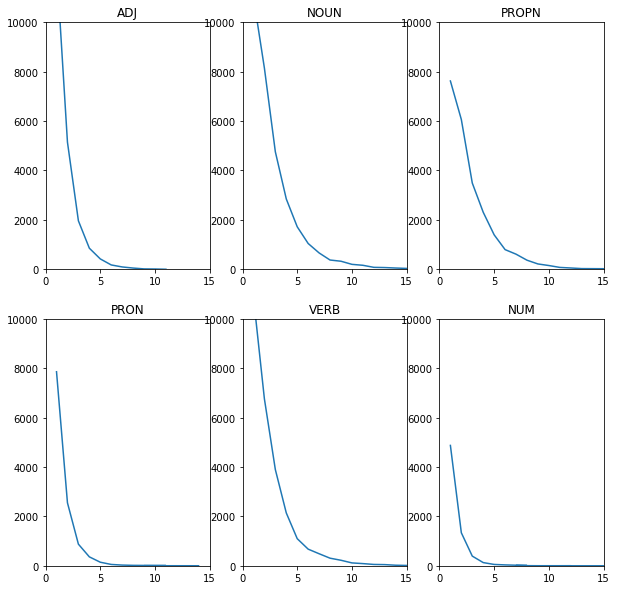

In [101]:
plt.figure(figsize = (10,10))
for i, c in enumerate(posInt):
    plt.subplot(2,3,i+1)
    plt.plot(X_train[X_train[c]!=0][c].value_counts())
    plt.title(c)
    plt.xlim(xmin = 0, xmax = 15)
    plt.ylim(ymin = 0, ymax = 10000 )
    

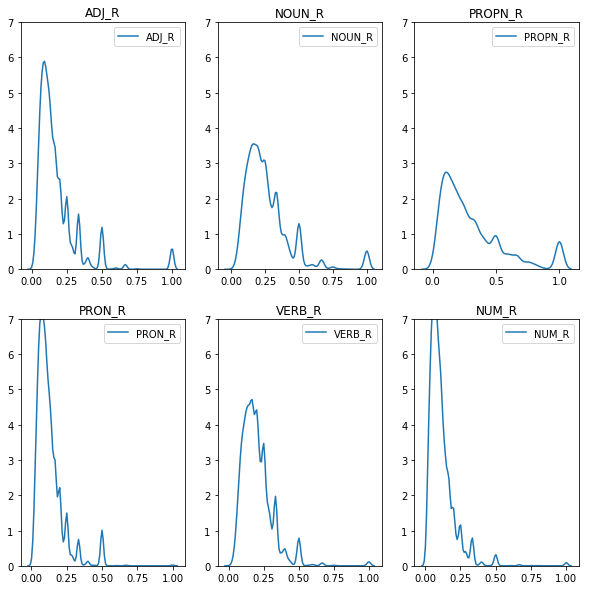

In [237]:
plt.figure(figsize = (10,10))
for i, c in enumerate(posIntR):
    plt.subplot(2,3,i+1)
    sns.kdeplot(X_train[X_train[c]!=0][c])
    plt.title(c)
    plt.ylim(ymin = 0, ymax = 7)

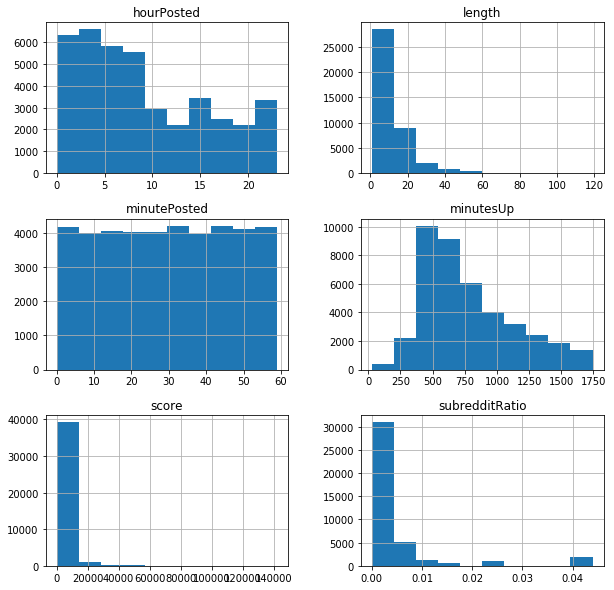

In [122]:
X_train[other].hist( figsize = (10,10));

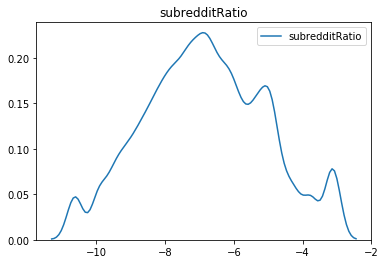

In [163]:
sns.kdeplot(np.log(X_train['subredditRatio']));
plt.title('subredditRatio');

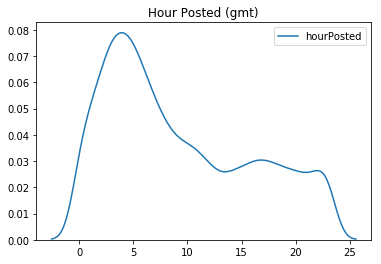

In [162]:
sns.kdeplot(X_train['hourPosted']);
plt.title('Hour Posted (gmt)');

In [318]:
np.percentile(y_train,99)

1358.7599999999948

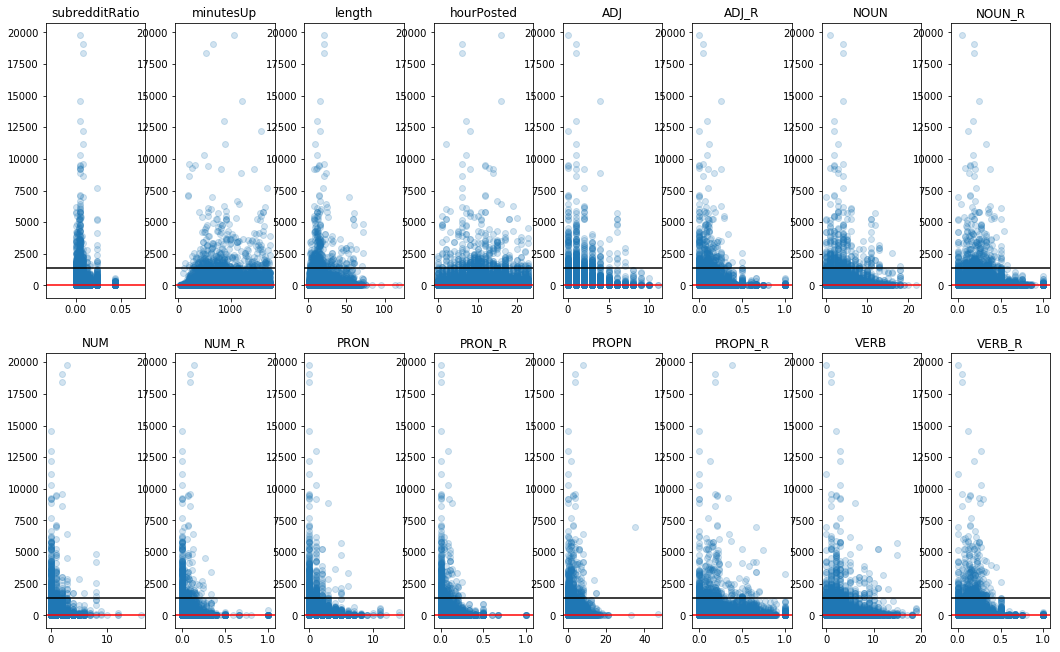

In [321]:
plt.figure(figsize = (18,12))
l= posInt + posIntR
l.sort()
for i, c in enumerate(['subredditRatio','minutesUp','length','hourPosted']+l):
    plt.subplot(2,8,i+1)
    plt.scatter(X_train[c],y_train, alpha = .2)
    plt.title(c)
    plt.axhline(np.median(y_train), c = 'r', label = 'median')
    plt.axhline(np.percentile(y_train, 99,),c = 'black', label = '99th %tile')
    #plt.legend()
plt.subplots_adjust(wspace = .3, bottom = .1, top =.8)

### Step 5: AWS CrossValidation

Searcher.py script run on AWS; to find potentially best models.  

Then load back results (forgive poor file names; first real experience with AWS)

In [189]:
with open('mods.pickle', 'rb') as f:
    mods = pickle.load(f)
    
modDf = pd.DataFrame(mods)
modDf['Type'] = [d.pop('name') for d in modDf[0]]
modDf.columns = ['Params', 'Score','Std','Time', 'Type']

In [221]:
top = []
for v in modDf['Type'].unique():
    idxs = modDf[modDf['Type']==v].sort_values('Score',ascending = False).head(5).index
    top.append(idxs)

nl = []
for l in top:
    for i in l:
        nl.append(modDf.loc[i])
ndf = pd.DataFrame(nl)

ndf

,Params,Score,Std,Time,Type
223,"{'penalty': 'l2', 'C': 48.9983892617}",0.618319,0.003053,9.796380,LogisticRegression
244,"{'penalty': 'l2', 'C': 63.0909395973}",0.618115,0.005076,10.427303,LogisticRegression
285,"{'penalty': 'l2', 'C': 90.604966443}",0.617503,0.002671,10.461934,LogisticRegression
125,"{'penalty': 'l1', 'C': 83.8942281879}",0.617452,0.000753,3.619003,LogisticRegression
78,"{'penalty': 'l1', 'C': 52.3537583893}",0.617401,0.007225,3.662433,LogisticRegression
404,"{'criterion': 'entropy', 'max_depth': 9, 'min_...",0.721491,0.006502,5.545128,DecisionTreeClassifier
346,"{'criterion': 'gini', 'max_depth': 9, 'min_sam...",0.719145,0.004988,4.149748,DecisionTreeClassifier
409,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.718584,0.005184,6.034030,DecisionTreeClassifier
397,"{'criterion': 'entropy', 'max_depth': 8, 'min_...",0.718074,0.007312,4.958245,DecisionTreeClassifier
347,"{'criterion': 'gini', 'max_depth': 9, 'min_sam...",0.717921,0.005466,4.147333,DecisionTreeClassifier


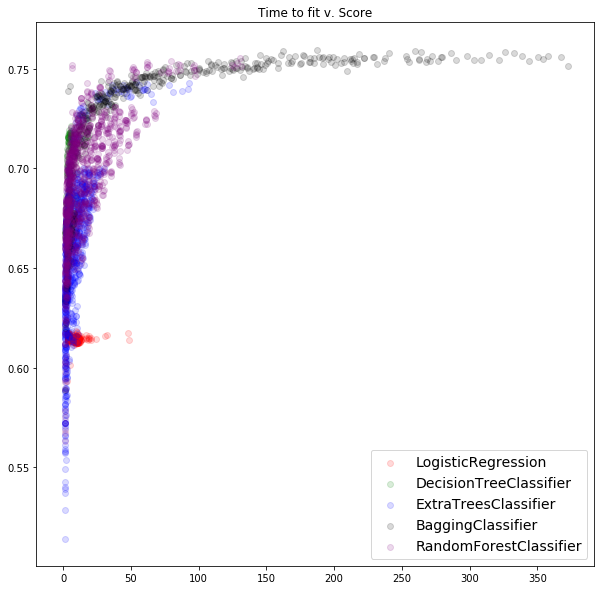

In [258]:
plt.figure(figsize = (10,10))
colors = ['r','g','b','black','purple']
for i, v in enumerate(modDf['Type'].unique()):
    #plt.subplot(3,2,i+1)
    plt.scatter(modDf[modDf['Type']==v]['Time'],modDf[modDf['Type']==v]['Score'], c=colors[i], alpha = .15, label = v)
plt.title('Time to fit v. Score')
plt.legend(fontsize = 14);

In [248]:
import pandas as pd

In [240]:
with open('mods2.pickle', 'rb') as f:
    mods2 = pickle.load(f)

In [250]:
with open('mods2.pickle', 'rb') as f:
    mods2 = pickle.load(f)
    
modDf2 = pd.DataFrame(mods2)
modDf2['Type'] = [d.pop('name') for d in modDf2[0]]
modDf2.columns = ['Params', 'Score','Std','Time', 'Type']

modDf2.head()

,Params,Score,Std,Time,Type
0,{'n_estimators': 25},0.703284,0.003971,1.310745,AdaBoostClassifier
1,{'n_estimators': 26},0.706548,0.005951,1.333040,AdaBoostClassifier
2,{'n_estimators': 27},0.702417,0.005002,1.379783,AdaBoostClassifier
3,{'n_estimators': 28},0.704304,0.006659,1.425457,AdaBoostClassifier
4,{'n_estimators': 29},0.701346,0.005855,1.477193,AdaBoostClassifier


In [251]:
top = []
for v in modDf2['Type'].unique():
    idxs = modDf2[modDf2['Type']==v].sort_values('Score',ascending = False).head(5).index
    top.append(idxs)

nl = []
for l in top:
    for i in l:
        nl.append(modDf2.loc[i])
ndf2 = pd.DataFrame(nl)

ndf2

,Params,Score,Std,Time,Type
168,{'n_estimators': 193},0.712260,0.003935,9.321027,AdaBoostClassifier
144,{'n_estimators': 169},0.711852,0.003525,8.060086,AdaBoostClassifier
170,{'n_estimators': 195},0.711597,0.008702,9.432739,AdaBoostClassifier
128,{'n_estimators': 153},0.711444,0.007681,7.394290,AdaBoostClassifier
122,{'n_estimators': 147},0.711393,0.004898,7.076983,AdaBoostClassifier
218,{'alpha': 4.4},0.566962,0.001687,0.135773,BernoulliNB
211,{'alpha': 3.7},0.566707,0.001939,0.136579,BernoulliNB
215,{'alpha': 4.1},0.566554,0.006354,0.136067,BernoulliNB
200,{'alpha': 2.6},0.566503,0.008615,0.138825,BernoulliNB
192,{'alpha': 1.8},0.566452,0.000721,0.133749,BernoulliNB


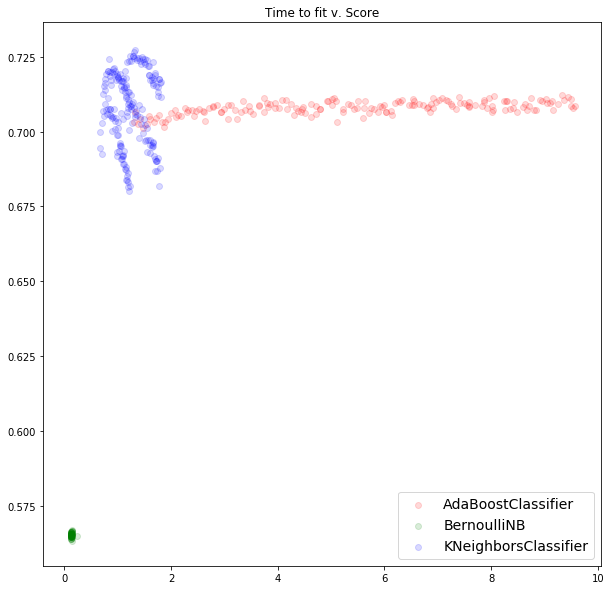

In [257]:
plt.figure(figsize = (10,10))
colors = ['r','g','b','black','purple']
for i, v in enumerate(modDf2['Type'].unique()):
    #plt.subplot(3,2,i+1)
    plt.scatter(modDf2[modDf2['Type']==v]['Time'],modDf2[modDf2['Type']==v]['Score'], c=colors[i], alpha = .15, label = v)
plt.title('Time to fit v. Score')
plt.legend(fontsize = 14);

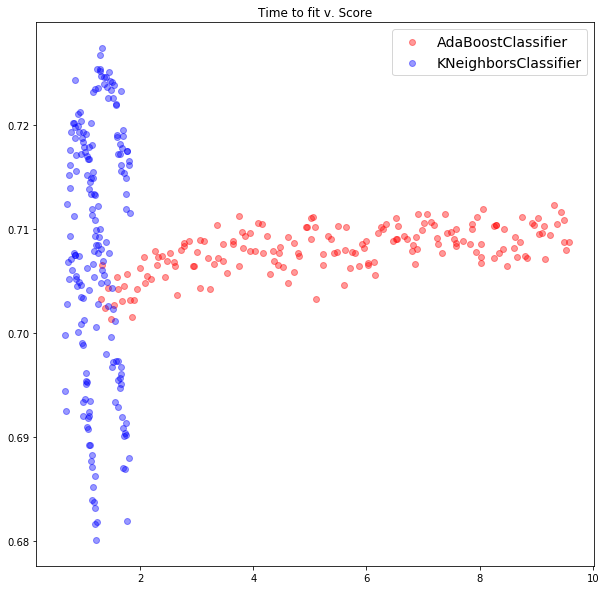

In [323]:
plt.figure(figsize = (10,10))
colors = ['r','b','black','purple']
for i, v in enumerate(['AdaBoostClassifier','KNeighborsClassifier']):
    #plt.subplot(3,2,i+1)
    plt.scatter(modDf2[modDf2['Type']==v]['Time'],modDf2[modDf2['Type']==v]['Score'], c=colors[i], alpha = .4, label = v)
plt.title('Time to fit v. Score')
plt.legend(fontsize = 14);

In [7]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
with open('SVM1Res.pickle', 'rb') as f:
    svm1 = pickle.load(f)
with open('SVM2Res.pickle', 'rb') as f:
    svm2 = pickle.load(f)
with open('GB3Res.pickle', 'rb') as f:
    gb3 = pickle.load(f)    
with open('GB1Res.pickle', 'rb') as f:
    gb1 = pickle.load(f)    
with open('GB2Res.pickle', 'rb') as f:
    gb2 = pickle.load(f)    

In [8]:
gb = pd.concat([pd.DataFrame(gb3), pd.DataFrame(gb2), pd.DataFrame(gb1)], axis = 'rows')

gb['Type'] = [d.pop('name') for d in gb[0]]
gb.columns = ['Params', 'Score','Std','Time', 'Type']

gb.sort_values('Score', ascending = False).head(5)

,Params,Score,Std,Time,Type
1664,"{'loss': 'deviance', 'learning_rate': 0.275555...",0.751734,0.003392,175.472864,GradientBoostingClassifier
4667,"{'loss': 'exponential', 'learning_rate': 0.275...",0.751632,0.003983,195.191854,GradientBoostingClassifier
1259,"{'loss': 'deviance', 'learning_rate': 0.204140...",0.751071,0.003312,210.055593,GradientBoostingClassifier
3839,"{'loss': 'exponential', 'learning_rate': 0.132...",0.750714,0.001251,222.752389,GradientBoostingClassifier
4259,"{'loss': 'exponential', 'learning_rate': 0.204...",0.750459,0.005461,222.466829,GradientBoostingClassifier


In [ ]:
gb.shape

In [14]:
svdf = pd.DataFrame(svm1)
svdf2 = pd.DataFrame(svm2)
svdf = pd.concat([svdf, svdf2], axis = 'rows')
svdf['Type'] = [d.pop('name') for d in svdf[0]]
svdf.columns = ['Params', 'Score','Std','Time', 'Type']

svdf.sort_values('Score', ascending=False).head(5)

,Params,Score,Std,Time,Type
44,"{'C': 0.774263682681, 'gamma': 0.00774263682681}",0.731997,0.004335,690.566704,SVC
54,"{'C': 1.29154966501, 'gamma': 0.00774263682681}",0.731232,0.000904,763.868459,SVC
80,"{'C': 5.99484250319, 'gamma': 0.001}",0.730722,0.000819,672.425541,SVC
82,"{'C': 5.99484250319, 'gamma': 0.00278255940221}",0.729549,0.005449,743.575463,SVC
81,"{'C': 5.99484250319, 'gamma': 0.0016681005372}",0.729294,0.003516,687.464274,SVC


In [3]:
svm2

[({'C': 10.0, 'gamma': 0.10000000000000001, 'name': 'SVC'},
  0.67992656058751544,
  0.0072487627415757181,
  429.8416037559509),
 ({'C': 10.0, 'gamma': 0.16681005372000587, 'name': 'SVC'},
  0.599704202366381,
  0.0072695441711470611,
  1248.2884023189545),
 ({'C': 10.0, 'gamma': 0.27825594022071243, 'name': 'SVC'},
  0.55411056711546303,
  0.0065645013911481793,
  1337.42578125),
 ({'C': 10.0, 'gamma': 0.46415888336127786, 'name': 'SVC'},
  0.54034067727458179,
  0.0049345893847090603,
  1365.599992275238),
 ({'C': 10.0, 'gamma': 0.774263682681127, 'name': 'SVC'},
  0.5387086903304773,
  0.0039266374041045148,
  1540.478925704956),
 ({'C': 10.0, 'gamma': 1.2915496650148841, 'name': 'SVC'},
  0.53146674826601381,
  0.012205002605368392,
  1395.6234712600708),
 ({'C': 10.0, 'gamma': 2.1544346900318834, 'name': 'SVC'},
  0.53605671154630763,
  0.0017504082315106504,
  1540.3433339595795),
 ({'C': 10.0, 'gamma': 3.5938136638046259, 'name': 'SVC'},
  0.53473072215422279,
  0.0019633187020

In [324]:
dtParams = modDf.loc[404]['Params']
bagParams = modDf.loc[1738]['Params']
adaParams = modDf2.loc[168]['Params']
dontFit = ['score','title','subreddit']

In [270]:
%%time
X_test, y_test = preproc(X_test, y_test, SRRatioDict)

Wall time: 2min 4s


In [326]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report

dt = DecisionTreeClassifier(**dtParams)
bag = BaggingClassifier(**bagParams)
ada = AdaBoostClassifier(**adaParams
                        )
med, ytr = target(y_train)

dt.fit(X_train[[c for c in X_train.columns if c not in dontFit]], ytr )
bag.fit(X_train[[c for c in X_train.columns if c not in dontFit]], ytr );
ada.fit(X_train[[c for c in X_train.columns if c not in dontFit]], ytr );

In [327]:
_, yts = target(y_test, med)
treePreds = dt.predict(X_test[[c for c in X_train.columns if c not in dontFit]])
bagPreds = bag.predict(X_test[[c for c in X_train.columns if c not in dontFit]])
adaPreds = ada.predict(X_test[[c for c in X_train.columns if c not in dontFit]])


print('Tree Score: ', dt.score(X_test[[c for c in X_train.columns if c not in dontFit]], yts ))
print(confusion_matrix(treePreds, yts))
print(classification_report(treePreds, yts))
print()
print('Bagging Score: ', bag.score(X_test[[c for c in X_train.columns if c not in dontFit]], yts ))
print(confusion_matrix(bagPreds, yts))
print(classification_report(bagPreds, yts))

Tree Score:  0.698255586045
[[3696 1695]
 [1384 3429]]
             precision    recall  f1-score   support

      False       0.73      0.69      0.71      5391
       True       0.67      0.71      0.69      4813

avg / total       0.70      0.70      0.70     10204


Bagging Score:  0.744315954528
[[3863 1392]
 [1217 3732]]
             precision    recall  f1-score   support

      False       0.76      0.74      0.75      5255
       True       0.73      0.75      0.74      4949

avg / total       0.74      0.74      0.74     10204



In [335]:
adaP = [int(p) for p in adaPreds]
bagP = [int(p) for p in bagPreds]
treeP = [int(p) for p in treePreds]
enP = list(zip(adaP, bagP, treeP))
enP = [np.sum(p)>1 for p in enP]
print(confusion_matrix(enP, yts))
print(classification_report(enP, yts))

[[3758 1478]
 [1322 3646]]
             precision    recall  f1-score   support

      False       0.74      0.72      0.73      5236
       True       0.71      0.73      0.72      4968

avg / total       0.73      0.73      0.73     10204



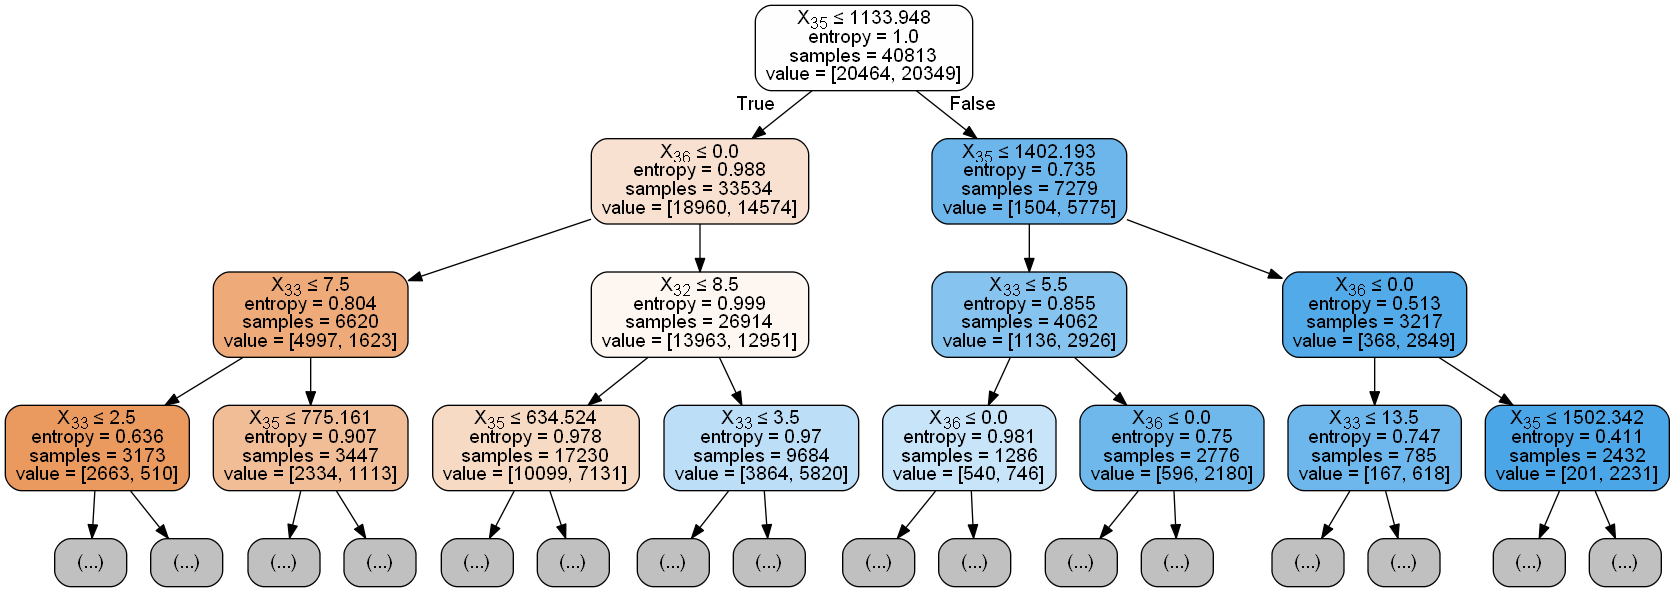

In [285]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()  

export_graphviz(dt, out_file=dot_data, max_depth = 3,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [296]:
X_train[[c for c in X_train.columns if c not in dontFit]].describe()

,ADJ,ADJ_R,ADP,ADP_R,ADV,ADV_R,CCONJ,CCONJ_R,DET,DET_R,...,SYM_R,VERB,VERB_R,X,X_R,hourPosted,length,minutePosted,minutesUp,subredditRatio
count,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000,...,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000,40813.000000
mean,0.892412,0.091677,0.966751,0.071005,0.520177,0.043188,0.183079,0.011807,0.759562,0.061649,...,0.004267,1.624654,0.131335,0.022566,0.005963,9.204543,11.128979,29.628746,776.114906,0.004600
std,1.203866,0.145668,1.341844,0.084170,0.939233,0.086658,0.475099,0.035409,1.100435,0.085464,...,0.024254,2.005414,0.130685,0.207795,0.058962,6.707171,10.028841,17.398527,356.219098,0.009550
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,29.336900,0.000025
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,5.000000,15.000000,502.371256,0.000319
50%,1.000000,0.040000,1.000000,0.051282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.125000,0.000000,0.000000,7.000000,8.000000,30.000000,683.269861,0.001054
75%,1.000000,0.133333,1.000000,0.125000,1.000000,0.066667,0.000000,0.000000,1.000000,0.111111,...,0.000000,2.000000,0.200000,0.000000,0.000000,15.000000,14.000000,45.000000,991.108012,0.004092
max,11.000000,1.000000,12.000000,1.000000,13.000000,1.000000,6.000000,0.500000,11.000000,1.000000,...,0.500000,19.000000,1.000000,15.000000,1.000000,23.000000,119.000000,59.000000,1742.720712,0.043981


In [288]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report

dtPerc = DecisionTreeClassifier(**dtParams)
bagPerc = BaggingClassifier(**bagParams)

perc, ytr = targetPerc(y_train)

dtPerc.fit(X_train[[c for c in X_train.columns if c not in dontFit]], ytr )
bagPerc.fit(X_train[[c for c in X_train.columns if c not in dontFit]], ytr );

In [290]:
_, yts = target(y_test, perc)
treePredsPerc = dtPerc.predict(X_test[[c for c in X_train.columns if c not in dontFit]])
bagPredsPerc = bagPerc.predict(X_test[[c for c in X_train.columns if c not in dontFit]])
print('Tree Score: ', dt.score(X_test[[c for c in X_train.columns if c not in dontFit]], yts ))
print(confusion_matrix(treePredsPerc, yts))
print(classification_report(treePredsPerc, yts))
print()
print('Bagging Score: ', bag.score(X_test[[c for c in X_train.columns if c not in dontFit]], yts ))
print(confusion_matrix(bagPreds, yts))
print(classification_report(bagPreds, yts))

Tree Score:  0.694629557036
[[5175 1962]
 [ 991 2076]]
             precision    recall  f1-score   support

      False       0.84      0.73      0.78      7137
       True       0.51      0.68      0.58      3067

avg / total       0.74      0.71      0.72     10204


Bagging Score:  0.728733829871
[[4315  917]
 [1851 3121]]
             precision    recall  f1-score   support

      False       0.70      0.82      0.76      5232
       True       0.77      0.63      0.69      4972

avg / total       0.74      0.73      0.73     10204



### Modeling on other splits (non-median)

Not Completed

In [294]:
scoreList=[]
for p in range(50,81,5):
    for clf in [dt, bag]:
        scores = crossValP(clf, X_train[[c for c in X_train.columns if c not in dontFit]], y_train, p)
        
        scoreList.append([(str(clf).split('.')[-1][:-2],p),np.mean(scores)])

In [298]:
str(bag)

'BaggingClassifier(base_estimator=None, bootstrap=True,\n         bootstrap_features=False, max_features=1.0,\n         max_samples=0.77775510204081633, n_estimators=60, n_jobs=1,\n         oob_score=False, random_state=None, verbose=0, warm_start=False)'

In [295]:
scoreList

[[("0, presort=False, random_state=None,\n            splitter='best", 50),
  0.94485294117647056],
 [('77775510204081633, n_estimators=60, n_jobs=1,\n         oob_score=False, random_state=None, verbose=0, warm_start=Fals',
   50),
  0.95009803921568614],
 [("0, presort=False, random_state=None,\n            splitter='best", 55),
  0.94545454545454544],
 [('77775510204081633, n_estimators=60, n_jobs=1,\n         oob_score=False, random_state=None, verbose=0, warm_start=Fals',
   55),
  0.94886057338887531],
 [("0, presort=False, random_state=None,\n            splitter='best", 60),
  0.94507352941176481],
 [('77775510204081633, n_estimators=60, n_jobs=1,\n         oob_score=False, random_state=None, verbose=0, warm_start=Fals',
   60),
  0.95107843137254899],
 [("0, presort=False, random_state=None,\n            splitter='best", 65),
  0.9470003680529997],
 [('77775510204081633, n_estimators=60, n_jobs=1,\n         oob_score=False, random_state=None, verbose=0, warm_start=Fals',
   65

### Searching/ Testing Algorithms

In [226]:
import numpy as np

def crossVal(clf, X, y, folds = 3):
    scores = []
    randOrd = np.random.permutation(len(y))
    slices = list(range(0,len(y)+1, int(len(y)/folds)))
    #print(slices)
    foldIndex = [randOrd[slice(slices[i],slices[i+1])] for i in range(folds) ]
    #print(foldIndex)
    for tfi in foldIndex:
        y_test = y.loc[tfi]
        X_test = X.loc[tfi]
        
        notTfi = [fi for fi in foldIndex if (fi != tfi).any()]
        train = [item for sublist in notTfi for item in sublist]
        y_train = y.loc[train]
        X_train = X.loc[train]
        
        med, y_train = target(y_train)
        _, y_test = target(y_test, med)
        
        clf.fit(X_train, y_train)
        
        scores.append(clf.score(X_test, y_test))
    
    return scores

In [291]:
import numpy as np

def crossValP(clf, X, y, folds = 3, perc = 60):
    scores = []
    randOrd = np.random.permutation(len(y))
    slices = list(range(0,len(y)+1, int(len(y)/folds)))
    #print(slices)
    foldIndex = [randOrd[slice(slices[i],slices[i+1])] for i in range(folds) ]
    #print(foldIndex)
    for tfi in foldIndex:
        y_test = y.loc[tfi]
        X_test = X.loc[tfi]
        
        notTfi = [fi for fi in foldIndex if (fi != tfi).any()]
        train = [item for sublist in notTfi for item in sublist]
        y_train = y.loc[train]
        X_train = X.loc[train]
        
        perc, y_train = targetPerc(y_train, perc = perc)
        _, y_test = target(y_test, perc)
        
        clf.fit(X_train, y_train)
        
        scores.append(clf.score(X_test, y_test))
    
    return scores

In [227]:
def searcher(paramDict, X, y):
    toRet = []
    
    for func in paramDict:
        optionsDict = paramDict[func]
        toTry = dictCompile(optionsDict)
        for argDict in toTry:
            scores = crossVal(func(**argDict), X, y)
            name = dict({'name':str(func).split('.')[-1][:-2]}, **argDict)
            
            toRet.append((name, np.mean(scores), np.std(scores)))
            
    return toRet

def dictCompile(funcDict):
    individualDicts = []
    
    for k in funcDict:
        individualDicts.append([{k:v} for v in funcDict[k]])

    return dictMaker(individualDicts)

def dictMaker(lst):
    toRet = []
    for d in lst[0]:
        if len(lst)>1:
            for ds in dictMaker(lst[1:]):
                toRet.append(dict(d,**ds))
        else:
            return lst[0]
    return toRet

In [743]:
%%time
X_test, y_test = preproc(X_test, y_test, SRRatioDict)

Wall time: 1min 16s


### Deprecated


### Scrape Via API

In [382]:
import json
import requests
import requests.auth

with open('api_key.json') as f:
    keys = json.loads(f.read())
client_auth = requests.auth.HTTPBasicAuth(keys['key'], keys['secret'])
post_data = {"grant_type": "password", "username": keys['username'], "password": keys['password']}
headers = {"User-Agent": "ChangeMeClient/0.1 by YourUsername"}
response = requests.post("https://www.reddit.com/api/v1/access_token", auth=client_auth, data=post_data, headers=headers)
access = response.json()

headers = {"Authorization": access['token_type'] + access['access_token'], # Not Tested
           "User-Agent": "GAProj by wipegup"} 
parameters = {
    'g':'US',
    'after':'' 
}

response = requests.get("https://oauth.reddit.com/hot", params = parameters, headers=headers)
dic = response.json()

{'access_token': 'Yx4h5tnBjf8Ntqq6PSUSlXH_m4g',
 'expires_in': 3600,
 'scope': '*',
 'token_type': 'bearer'}

In [445]:
import pprint
pprint.pprint(vars(sub))

{'_comments': <praw.models.comment_forest.CommentForest object at 0x000002717A3D8160>,
 '_comments_by_id': {'t1_duljez3': Comment(id='duljez3'),
                     't1_duljh6z': Comment(id='duljh6z'),
                     't1_duljlqk': Comment(id='duljlqk'),
                     't1_dulk5xx': Comment(id='dulk5xx'),
                     't1_dulk9jr': Comment(id='dulk9jr'),
                     't1_dulkbn3': Comment(id='dulkbn3'),
                     't1_dulkdih': Comment(id='dulkdih'),
                     't1_dulkdmp': Comment(id='dulkdmp'),
                     't1_dulkfpg': Comment(id='dulkfpg'),
                     't1_dulkjao': Comment(id='dulkjao'),
                     't1_dulkn2o': Comment(id='dulkn2o'),
                     't1_dulkro5': Comment(id='dulkro5'),
                     't1_dulkrx4': Comment(id='dulkrx4'),
                     't1_dulksvq': Comment(id='dulksvq'),
                     't1_dulkv70': Comment(id='dulkv70'),
                     't1_dulkwxt': Comment(

 'edited': False,
 'gilded': 0,
 'hidden': False,
 'hide_score': False,
 'id': '7z610w',
 'is_crosspostable': False,
 'is_reddit_media_domain': True,
 'is_self': False,
 'is_video': False,
 'likes': None,
 'link_flair_css_class': None,
 'link_flair_text': None,
 'locked': False,
 'media': None,
 'media_embed': {},
 'mod_note': None,
 'mod_reason_by': None,
 'mod_reason_title': None,
 'mod_reports': [],
 'name': 't3_7z610w',
 'num_comments': 269,
 'num_crossposts': 0,
 'num_reports': None,
 'over_18': False,
 'parent_whitelist_status': 'all_ads',
 'permalink': '/r/pics/comments/7z610w/on_the_left_scene_from_the_first_season_of/',
 'pinned': False,
 'post_hint': 'image',
 'preview': {'enabled': True,
             'images': [{'id': 'gHJAoXcyBHNy0Pj7BNQtmttNn5RFoqcNOigyPwdhNYg',
                         'resolutions': [{'height': 82,
                                          'url': 'https://i.redditmedia.com/pMZ47pZrbPeR2EV74JiDU1EQZaGjHdbcdKHJfcbelRU.jpg?fit=crop&crop=faces%2Centropy&arh=

#### Deprecated Praw Function

In [453]:
def prawScrapeTodf(prawList):
    df = pd.DataFrame(prawList)
    df['timePosted'] = [pd.to_datetime(datetime.datetime.fromtimestamp(t)) for t in df['timePosted']]
    df['timeScraped'] = [pd.to_datetime(datetime.datetime.fromtimestamp(t)) for t in df['timeScraped']]
    df['timePosted']=[t- pd.Timedelta(hours = 5) # convert from UTC
                            for t in df['timePosted']]
    
    df['timeUp'] = df['timeScraped'] - df['timePosted']
    
    return df